In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import pysal as ps
import numpy as np
import statsmodels as sm

In [2]:
# load county gdf
gdf_us = gpd.read_file('data/outputs/683data').set_index('GEOID')

# use USA Contiguous Equidistant Conic projection
us_crs = 'ESRI:102005'
gdf_us = gdf_us.to_crs(us_crs)

gdf_us.shape

(3108, 52)

In [3]:
gdf_us['med_homeval_k'] = gdf_us['med_homeva']/1000
gdf_us['med_rent_k'] = gdf_us['med_rent']/1000
gdf_us['inc_pc_k'] = gdf_us['inc_pc']/1000
gdf_us['med_inc_k'] = gdf_us['inc_pc']/1000
gdf_us['pct_moved'] = gdf_us['pct_moved1'] + gdf_us['pct_move_1']
gdf_us['log_pop'] = np.log(gdf_us['pop'])
gdf_us['log_popdens'] = np.log(gdf_us['pop_dens'])

In [4]:
# choose which variables to use as predictors
predictors = ['pct_bach', 'log_popdens', 'pct_black','pct_hisp', 'TOTRATE', 'pct_dem', 'pct_20_34',
              'pct_fb',]

# choose a response variable
response = 'cohab'

In [5]:
gdf_us[predictors].corr()

,pct_bach,log_popdens,pct_black,pct_hisp,TOTRATE,pct_dem,pct_20_34,pct_fb
pct_bach,1.000000,0.444151,-0.089785,-0.015421,-0.049725,0.428916,0.293529,0.364769
log_popdens,0.444151,1.000000,0.237558,-0.044389,-0.163565,0.499554,0.426562,0.338401
pct_black,-0.089785,0.237558,1.000000,-0.111777,0.004838,0.514940,0.241372,-0.000278
pct_hisp,-0.015421,-0.044389,-0.111777,1.000000,0.117229,0.178443,0.202675,0.673691
TOTRATE,-0.049725,-0.163565,0.004838,0.117229,1.000000,-0.148123,-0.059162,-0.012385
pct_dem,0.428916,0.499554,0.514940,0.178443,-0.148123,1.000000,0.381874,0.390044
pct_20_34,0.293529,0.426562,0.241372,0.202675,-0.059162,0.381874,1.000000,0.321706
pct_fb,0.364769,0.338401,-0.000278,0.673691,-0.012385,0.390044,0.321706,1.000000


## 1. Global OLS

In [6]:
# create design matrix of predictors (drop nulls) and response matrix
X = gdf_us[predictors].dropna()
Y = gdf_us.loc[X.index][[response]]

# estimate linear regression model with OLS
ols = ps.model.spreg.OLS(y=Y.values,
                         x=X.values,
                         name_x=X.columns.tolist(),
                         name_y=response,
                         name_ds='counties')
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :    counties
Weights matrix      :        None
Dependent Variable  :       cohab                Number of Observations:        3107
Mean dependent var  :      5.8032                Number of Variables   :           9
S.D. dependent var  :      1.8446                Degrees of Freedom    :        3098
R-squared           :      0.3001
Adjusted R-squared  :      0.2983
Sum squared residual:    7396.517                F-statistic           :    166.0509
Sigma-square        :       2.388                Prob(F-statistic)     :   1.51e-233
S.E. of regression  :       1.545                Log likelihood        :   -5756.073
Sigma-square ML     :       2.381                Akaike info criterion :   11530.145
S.E of regression ML:      1.5429                Schwarz criterion     :   11584.518

-----------------------------------------------------------------------------

### 1.1. VIF

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# the independent variables set
X = gdf_us[predictors].dropna()
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

       feature        VIF
0     pct_bach  12.233800
1  log_popdens   6.619551
2    pct_black   2.624579
3     pct_hisp   3.946816
4      TOTRATE   7.094842
5      pct_dem  12.908969
6    pct_20_34  16.798297
7       pct_fb   4.734117


### 1.2. Outcome Moran's I

In [8]:
# spatial weight matrix
w_queen = ps.lib.weights.Queen.from_dataframe(gdf_us[['cohab', 'geometry']])
w_queen.set_transform('R')

('WARNING: ', 1192, ' is an island (no neighbors)')
('WARNING: ', 2946, ' is an island (no neighbors)')


/Users/marley/opt/miniconda3/envs/ppd599/lib/python3.9/site-packages/pysal/lib/weights/weights.py:167: UserWarning: There are 2 disconnected observations 
  Island ids: 1192, 2946
  warnings.warn("There are %d disconnected observations" % ni + ' \n '


In [9]:
# calculate
y = gdf_us['cohab']
y_lag = ps.lib.weights.lag_spatial(w_queen, gdf_us['cohab'])

col = 'cohab'
col_lag = 'cohab_lag'
data_lag = pd.DataFrame(data={col:y, col_lag:y_lag}).astype(float)

# calculate the statistic
mi = ps.explore.esda.Moran(data_lag[col], w_queen)
mi.I

0.34414495534545836

### 1.3. Plot and Moran's I on Residuals

In [10]:
# grab residuals
res = list(map(list,list(ols.u)))
residuals = [item for sublist in res for item in sublist]
len(residuals)

3107

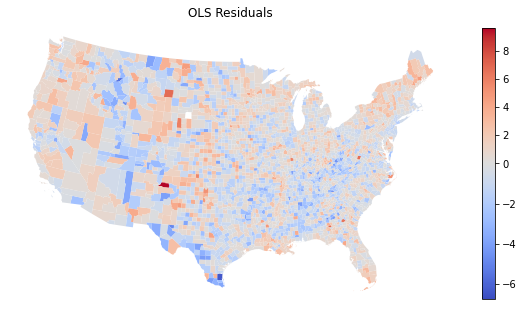

In [11]:
from matplotlib.colors import TwoSlopeNorm

# create residuals column
r = gdf_us[predictors].dropna()
r = gdf_us.loc[r.index]
r['residuals'] = residuals

# normalize color
vmin, vmax, vcenter = r.residuals.min(), r.residuals.max(), 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# create a normalized colorbar
cmap = 'coolwarm'
cbar = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# plot
fig, ax = plt.subplots(figsize=(10, 10))
r.plot(ax=ax, column='residuals', cmap=cmap, legend=False, norm=norm,) #scheme='StdMean')

# add colorbar
fig.colorbar(cbar, ax=ax, shrink=0.5)

plt.title(label='OLS Residuals')
ax.set_axis_off()
#fig.savefig('output/OLSresiduals.png', dpi=600, bbox_inches='tight')

## 2. Geographically weighted regression

In [12]:
fixed_kernel = False
spatial_kernel = 'Gaussian'
search = 'golden_section'
criterion = 'AICc'

In [13]:
%%time
# select an adaptive (NN) bandwidth for our GWR model, given the data
centroids = gdf_us.loc[X.index].centroid
coords = list(zip(centroids.x, centroids.y))
sel = ps.model.mgwr.sel_bw.Sel_BW(coords=coords,
                                  y=Y.values,
                                  X_loc=X.values,
                                  kernel=spatial_kernel,
                                  fixed=fixed_kernel)
nn = sel.search(search_method=search,) #criterion=criterion)

CPU times: user 3min 23s, sys: 36 s, total: 3min 59s
Wall time: 35.2 s


In [14]:
# what is the selected adaptive bandwidth value?
# ie, number of NNs to use to determine locally-varying bandwidth distances
nn

60.0

In [15]:
%%time
# estimate the GWR model parameters
# pass fixed=False to treat bw as number of NNs (adaptive kernel)
model = ps.model.mgwr.gwr.GWR(coords=coords,
                              y=Y.values,
                              X=X.values,
                              bw=nn,
                              kernel=spatial_kernel,
                              fixed=fixed_kernel)
gwr = model.fit()

CPU times: user 17.3 s, sys: 2.35 s, total: 19.7 s
Wall time: 2.58 s


In [16]:
# inspect the results
gwr.summary()

Model type                                                         Gaussian
Number of observations:                                                3107
Number of covariates:                                                     9

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           7396.517
Log-likelihood:                                                   -5756.073
AIC:                                                              11530.145
AICc:                                                             11532.217
BIC:                                                             -17515.780
R2:                                                                   0.300
Adj. R2:                                                              0.298

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [17]:
# a constant was added, so add to predictors
cols = ['constant'] + predictors
cols

['constant',
 'pct_bach',
 'log_popdens',
 'pct_black',
 'pct_hisp',
 'TOTRATE',
 'pct_dem',
 'pct_20_34',
 'pct_fb']

### 2.1. Visualize GWR parameters

In [18]:
# helper function to generate colormaps for GWR plots
def get_cmap(values, cmap_name='coolwarm', n=256):
    import numpy as np
    from matplotlib.colors import LinearSegmentedColormap as lsc
    name = f'{cmap_name}_new'
    cmap = plt.cm.get_cmap(cmap_name)
    vmin = values.min()
    vmax = values.max()

    if vmax < 0:
        # if all values are negative, use the negative half of the colormap
        return lsc.from_list(name, cmap(np.linspace(0, 0.5, n)))
    elif vmin > 0:
        # if all values are positive use the positive half of the colormap
        return lsc.from_list(name, cmap(np.linspace(0.5, 1, n)))
    else:
        # otherwise there are positive and negative values so use zero as midpoint
        # and truncate the colormap such that if the original spans ± the greatest
        # absolute value, we only use colors from it spanning vmin to vmax
        abs_max = max(values.abs())
        start = (vmin + abs_max) / (abs_max * 2)
        stop = (vmax + abs_max) / (abs_max * 2)
        return lsc.from_list(name, cmap(np.linspace(start, stop, n)))

In [19]:
# turn GWR local parameter estimates into a GeoDataFrame with tract geometries
params = pd.DataFrame(gwr.params, columns=cols, index=X.index)
params = gdf_us[['geometry']].merge(params, left_index=True, right_index=True, how='right')

In [20]:
# turn GWR local t stastics into GDF
tvals = pd.DataFrame(gwr.filter_tvals(alpha=0.05), columns=cols, index=X.index).clip(-4, 4)
tvals = gdf_us[['geometry']].merge(tvals, left_index=True, right_index=True, how='right')

In [21]:
# mask all insignificant parameter estmates (|t| ≥ 1.96)
mask = abs(tvals[cols]) >= 1.96
gdf_sig = params[cols][mask]
gdf = gdf_us[['geometry']].merge(gdf_sig, left_index=True, right_index=True, how='inner')
gdf_nona = gdf.fillna(value=0)

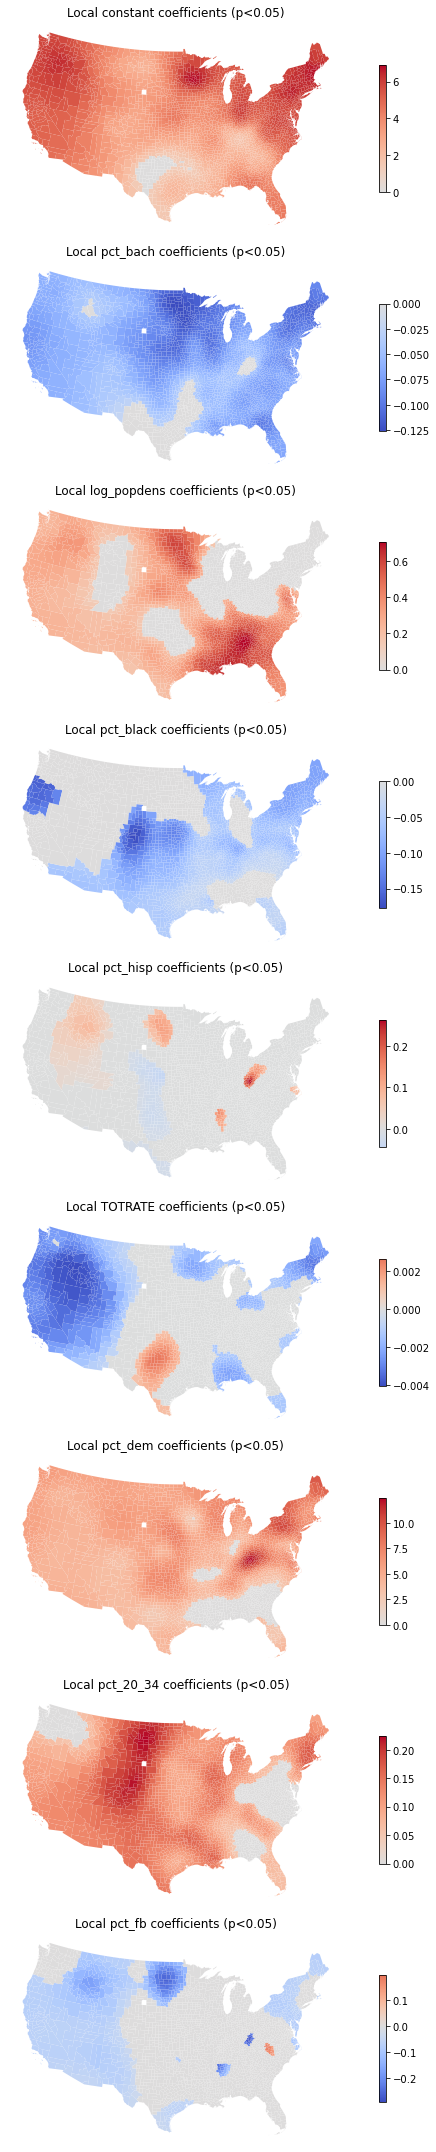

In [22]:
# plot significant parameters
fig, axes = plt.subplots(nrows=9, ncols=1, figsize=(10, 30))
for col, ax in zip(cols, axes.flat):
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f'Local {col} coefficients (p<0.05)')
    ax = gdf_nona.plot(ax=ax,
                  column=col,
                  cmap=get_cmap(gdf_nona[col]),
                  legend=True,
                  legend_kwds={'shrink': 0.6})

fig.tight_layout()
#fig.savefig('output/GWR1.png', dpi=600, bbox_inches='tight')

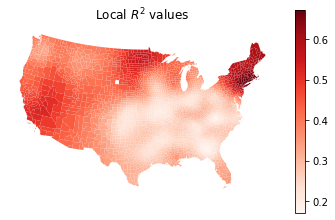

In [23]:
# turn GWR local R-squared values into a GeoDataFrame with tract geometries
col = 'Local $R^2$ values'
r_squared = pd.DataFrame(gwr.localR2, index=X.index, columns=[col])
r_squared = gdf_us[['geometry']].merge(r_squared, left_index=True, right_index=True, how='right')

# plot the spatial distribution of local R-squared values
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')
ax.axis('off')
ax.set_title(col)
gdf = r_squared.dropna(subset=[col], axis='rows')
ax = gdf.plot(ax=ax,
              column=col,
              cmap='Reds',
              legend=True,
              legend_kwds={'shrink': 0.6})
fig.tight_layout()

### 2.2. Local VIF

In [24]:
LCC, VIF, CN, VDP = gwr.local_collinearity()

In [25]:
vif = pd.DataFrame(data=VIF, index=gdf_us[predictors].dropna().index, columns=predictors)

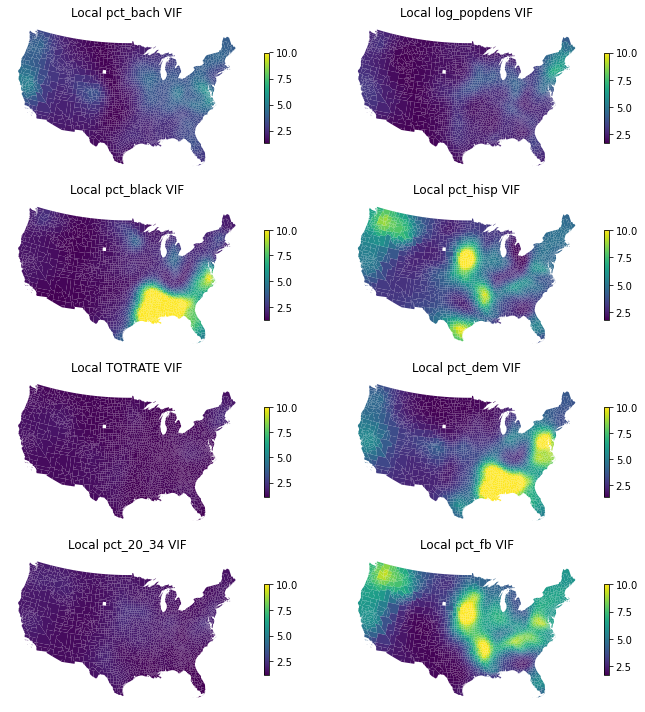

In [28]:
gdf_vif = gdf_us[['geometry']].merge(vif, left_index=True, right_index=True, how='inner')

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
for col, ax in zip(predictors, axes.flat):
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f'Local {col} VIF')
    ax = gdf_vif.plot(ax=ax,
                      vmax=10,
                      column=col,
                      cmap='viridis',
                      legend=True,
                      legend_kwds={'shrink': 0.6})
fig.tight_layout()
#fig.savefig('output/GWR_sample_vif.png', dpi=600, bbox_inches='tight')

### 2.3. GWR Residuals

In [29]:
residuals = gwr.resid_response
u = gdf_us[predictors].dropna()
u = gdf_us.loc[u.index]
u['residuals'] = residuals

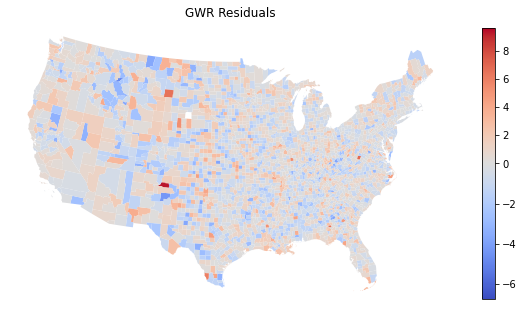

In [30]:
# create residuals column
residuals = gwr.resid_response
u = gdf_us[predictors].dropna()
u = gdf_us.loc[u.index]
u['residuals'] = residuals

# normalize color
vmin, vmax, vcenter = r.residuals.min(), r.residuals.max(), 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# create a normalized colorbar
cmap = 'coolwarm'
cbar = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# plot
fig, ax = plt.subplots(figsize=(10, 10))
u.plot(ax=ax, column='residuals', cmap=cmap, legend=False, norm=norm) #scheme='StdMean')

# add colorbar
fig.colorbar(cbar, ax=ax, shrink=0.5)

plt.title(label='GWR Residuals')
ax.set_axis_off()
#fig.savefig('output/OLSresiduals.png', dpi=600, bbox_inches='tight')

In [31]:
# morans I on residuals
w_queen = ps.lib.weights.Queen.from_dataframe(u[['residuals', 'geometry']])
w_queen.set_transform('R')

('WARNING: ', 1192, ' is an island (no neighbors)')
('WARNING: ', 2945, ' is an island (no neighbors)')


/Users/marley/opt/miniconda3/envs/ppd599/lib/python3.9/site-packages/pysal/lib/weights/weights.py:167: UserWarning: There are 2 disconnected observations 
  Island ids: 1192, 2945
  warnings.warn("There are %d disconnected observations" % ni + ' \n '


In [32]:
y = u['residuals']
u_lag = ps.lib.weights.lag_spatial(w_queen, u['residuals'])

col = 'residuals'
col_lag = 'residuals_lag'
data_lag = pd.DataFrame(data={col:y, col_lag:u_lag}).astype(float)

# calculate the statistic
mi = ps.explore.esda.Moran(data_lag[col], w_queen)
print(mi.I)
print(mi.p_sim)

0.06086203546298587
0.001


## 6. Spatial diagnostics

In [33]:
# compute spatial weights for only those tracts that appear in design matrix
W = ps.lib.weights.Queen.from_dataframe(gdf_us.loc[X.index])
W.transform = 'r'

('WARNING: ', 1192, ' is an island (no neighbors)')
('WARNING: ', 2945, ' is an island (no neighbors)')


/Users/marley/opt/miniconda3/envs/ppd599/lib/python3.9/site-packages/pysal/lib/weights/weights.py:167: UserWarning: There are 2 disconnected observations 
  Island ids: 1192, 2945
  warnings.warn("There are %d disconnected observations" % ni + ' \n '


In [34]:
# compute OLS spatial diagnostics to check the nature of spatial dependence
ols = ps.model.spreg.OLS(y=Y.values,
                         x=X.values,
                         w=W,
                         spat_diag=True,
                         moran=True)

In [35]:
# calculate moran's I (for the response) and its significance
mi = ps.explore.esda.Moran(y=Y, w=W, two_tailed=True)
print(mi.I)
print(mi.p_sim)

0.3441357572575046
0.001


In [36]:
# moran's I (for the residuals): moran's i, standardized i, p-value
ols.moran_res

(0.18777740230364046, 17.658118441187735, 8.81288006594854e-70)

In [37]:
# lagrange multiplier test for spatial lag model: stat, p
ols.lm_lag

(272.21622494411815, 3.7316410310211195e-61)

In [38]:
# lagrange multiplier test for spatial error model: stat, p
ols.lm_error

(303.597119341639, 5.421200988174536e-68)

In [39]:
# robust lagrange multiplier test for spatial lag model: stat, p
ols.rlm_lag

(3.8315681764468446, 0.050295854871074346)

In [40]:
# robust lagrange multiplier test for spatial error model: stat, p
ols.rlm_error

(35.212462573967656, 2.9562565103785417e-09)

## 7. Spatial Error model

In [42]:
# maximum-likelihood estimation with full matrix expression
mle = ps.model.spreg.ML_Error(y=Y.values,
                              x=X.values,
                              w=W,
                              method='full',
                              name_w='queen',
                              name_x=X.columns.tolist(),
                              name_y=response,
                              name_ds='tracts')
print(mle.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :      tracts
Weights matrix      :       queen
Dependent Variable  :       cohab                Number of Observations:        3107
Mean dependent var  :      5.8032                Number of Variables   :           9
S.D. dependent var  :      1.8446                Degrees of Freedom    :        3098
Pseudo R-squared    :      0.2923
Sigma-square ML     :       2.123                Log likelihood        :   -5629.102
S.E of regression   :       1.457                Akaike info criterion :   11276.204
                                                 Schwarz criterion     :   11330.577

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

In [43]:
# the spatial autoregressive parameter estimate, lambda
mle.lam

0.4090991099801928